# Multi-class Classification on Stack Overflow Questions



A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). The task is to take a question as input, and predict the appropriate tag.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
import re
import tensorflow as tf
import string
import os

## Data Loading

In [5]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

In [6]:

data_dir ="/kaggle/working/stack_overflow_16k"
print(os.listdir(data_dir))

['README.md', 'train', 'test']


In [7]:
train_dir = os.path.join(data_dir,"train")
print("train_dir:", os.listdir(train_dir))
test_dir = os.path.join(data_dir,"test")
print("test_dir:", os.listdir(test_dir))


train_dir: ['python', 'java', 'javascript', 'csharp']
test_dir: ['python', 'java', 'javascript', 'csharp']


In [8]:
sample_file = os.path.join(train_dir,"python/0.txt")
with open(sample_file) as p:
  print(p.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

## Data Preprocessing

In [9]:
#divide data into traina/val and assigns classes alphabetically.
#i.e csharp,java,javascript,and python take class,0,1,2,3 respectively
# each folder is class of its own
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    validation_split=.2,
    subset="training",
    seed=2025,
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    subset="validation",
    seed=2025,
    validation_split=.2
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=32,
    shuffle=False
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2025-12-17 11:24:44.031462: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['csharp', 'java', 'javascript', 'python']


In [11]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(f"Que {i}:", text_batch.numpy()[i])
    print(f"label {i}:", label_batch.numpy()[i])

Que 0: b'"rand a value different than i have an enum:..public enum privilegedaccounts.{.    user = 1,.    service = 16,.    admin = 64,.    other = 1040,.    executive = 2048.}...and i wish to rand a value different than user..i know there\'s this rand (not sure it\'s true):..foo = (privilegedaccounts) (rand());...but how do i make it to rand any value except for ""user""?..thank you,"\n'
label 0: 0
Que 1: b'"sample code or project for facial recognition using blank.net without using third party libraries? i want sample code for facial recognition using blank.net without using third party libraries..i want to achieve this using microsoft libraries..i gone through this link ""http://www.codeproject.com/articles/239849/multiple-face-detection-and-recognition-in-real-ti"" but in that link they have used ""emgu.cv.dll"" and some other external os libraries(dlls)..i want to know whether these dlls are open source libraries??.how can i achieve this task using microsoft or open source dlls??.

### Text Vectorization

In [12]:
def custom_standardization(input_data):

    lowercase = tf.strings.lower(input_data)

    # Replace HTML entities with a space
    stripped_html_entities = tf.strings.regex_replace(lowercase, '&lt;', ' ')
    stripped_html_entities = tf.strings.regex_replace(stripped_html_entities, '&gt;', ' ')
    stripped_html_entities = tf.strings.regex_replace(stripped_html_entities, '&amp;', ' ')

    stripped_slashes = tf.strings.regex_replace(stripped_html_entities, r'\\', ' ')
    stripped_quotes = tf.strings.regex_replace(stripped_slashes, '"', ' ')

    # Remove punctuations
    punctuation_to_remove = string.punctuation.replace("'", "")

    final_text = tf.strings.regex_replace(stripped_quotes,
                                          '[%s]' % re.escape(punctuation_to_remove),
                                          '')
    cleaned_text = tf.strings.regex_replace(final_text, r'\s+', ' ')

    return tf.strings.strip(cleaned_text)

In [13]:
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    output_mode='int',
    max_tokens=10000,
    output_sequence_length=256
)

In [14]:
train_text = train_ds.map(lambda text,label: text)
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text,label):
  text= tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [16]:
text_batch, label_batch = next(iter(train_ds))
first_que, first_label = text_batch[0], label_batch[0]


In [17]:
first_que, first_label

(<tf.Tensor: shape=(), dtype=string, numpy=b'"file contaning \xc3\xbf symbol while saving text file as binary data i am saving .txt file as a binary format.but at the last line of a binary file,one more character is saved i.e  \xc3\xbf..why this has happened ?.my code is like this :..fileoutputstream fout = null;.inputstream fin;.string path=""something"";.int i = 0;.fout = new fileoutputstream(path);.do {.  i=fin.read();.  fout.write(i);.} while(i != -1);.fout.flush();.fout.close();"\n'>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>)

In [18]:
print("Label",train_ds.class_names[first_label])
print("Vectorized review:\n", vectorize_text(first_que, first_label))

Label java
Vectorized review:
 (<tf.Tensor: shape=(1, 256), dtype=int64, numpy=
array([[  39,    1,    1,  978,  113, 1652,   91,   39,   35,  861,   82,
           3,   36, 1652,  717,   39,   35,    5,  861,    1,   64,    2,
         219,   79,    9,    5,  861,    1,  194,  394,    6, 1079,  434,
           1,   13,  104, 2778,   24,   30,    6,   50,   13, 2074,    1,
           1,    1,  249,  150,   29,    3,    1,   15,    1,    1,    1,
        5577,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 

In [19]:
#learned embedding vocabulary
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print("   0 ---> ",vectorize_layer.get_vocabulary()[0])
print("   1 ---> ",vectorize_layer.get_vocabulary()[1])
print("   2 ---> ",vectorize_layer.get_vocabulary()[2])




print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  equivalent
 313 --->  go
   0 --->  
   1 --->  [UNK]
   2 --->  the
Vocabulary size: 10000


In [20]:
#vectorize data
train_set = train_ds.map(vectorize_text)
test_set = test_ds.map(vectorize_text)
val_set = val_ds.map(vectorize_text)

## Configure data for perfomance

In [21]:
# Performance Optimization

# Use AUTOTUNE to let TensorFlow determine optimal buffer sizes based on system resources.
AUTOTUNE = tf.data.AUTOTUNE

# .cache(): Caches the dataset in memory or on local disk after the first epoch.
# This skips re-running the costly I/O and vectorization steps in subsequent epochs.
# .prefetch(): Overlaps data preprocessing (CPU) with model training (GPU/TPU).
# While the model trains on the current batch, the next batch is being loaded and prepared.
train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# The datasets are now fully prepared, vectorized, and optimized for model training.

## The Model

In [22]:
# qxn cxn model
max_features = 10000
embedding_dim = 16

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_features,embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

### Model compilation and Training

In [23]:
model.compile(
    metrics=['accuracy'],
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy'
)
early_stoppings = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(train_set,
                    validation_data=val_set,
                    verbose=1,
                    callbacks=[early_stoppings],
                    epochs=50
                    )

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3180 - loss: 1.3802 - val_accuracy: 0.4263 - val_loss: 1.3471
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4344 - loss: 1.3344 - val_accuracy: 0.5069 - val_loss: 1.2789
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5452 - loss: 1.2569 - val_accuracy: 0.5781 - val_loss: 1.1856
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6096 - loss: 1.1559 - val_accuracy: 0.6619 - val_loss: 1.0875
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6734 - loss: 1.0546 - val_accuracy: 0.6819 - val_loss: 1.0015
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7111 - loss: 0.9636 - val_accuracy: 0.7006 - val_loss: 0.9284
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7420 - loss: 0.8860 - val_accuracy: 0.7069 - val_loss: 0.8701
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7573 - loss: 0.8215 - val_accuracy: 0.

### Model Evaluation

In [24]:
metrics = model.evaluate(test_set,return_dict=True)
print(metrics)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7853 - loss: 0.5538
{'accuracy': 0.8078749775886536, 'loss': 0.5044335126876831}


## Model Training and Loss Visualization

In [25]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


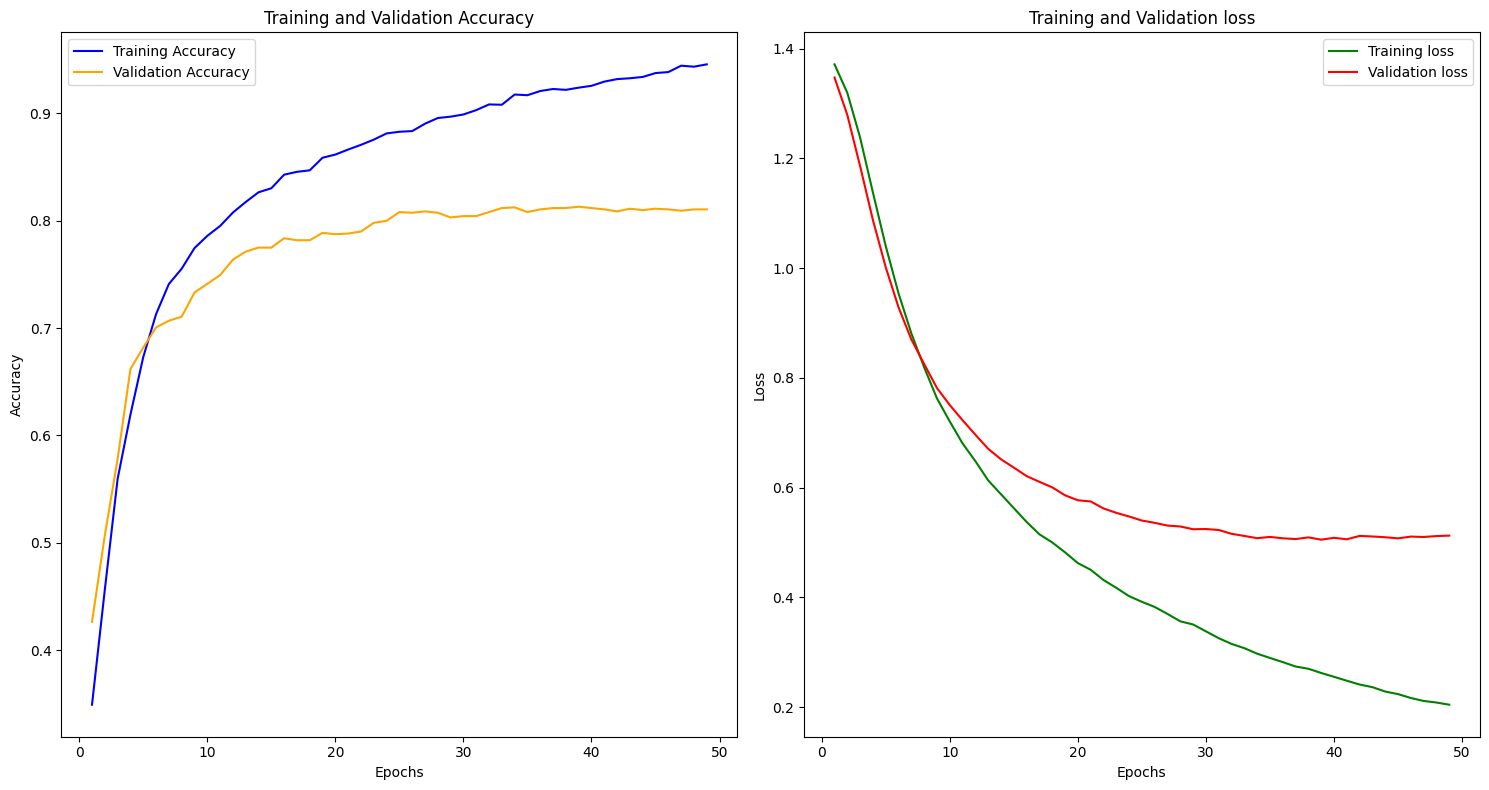

In [26]:
train_accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1,len(train_accuracy)+1)
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(epochs,train_accuracy,label="Training Accuracy",color='blue')
plt.plot(epochs,val_accuracy,label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs,train_loss,label="Training loss",color='green')
plt.plot(epochs,val_loss,label="Validation loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation loss")
plt.legend()

plt.tight_layout()


## Inference Model

In [28]:
inference_model = tf.keras.models.Sequential([
    vectorize_layer,
    model
])

# test the inference model
inference_model.compile(
    metrics=['accuracy'],
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy'
)

inf_metrics=inference_model.evaluate(test_ds, return_dict=True)
print(inf_metrics)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7853 - loss: 0.5538
{'accuracy': 0.8078749775886536, 'loss': 0.5044335126876831}


### Inference Examples

In [30]:
# 10 Inference Examples for Multi-class Classification
inference_data = tf.constant([
    # Expecting: Python (Tag 3)
    "How can I use list comprehensions to filter a list of dictionaries based on a key value?",
    "I'm getting a 'TypeError: 'tuple' object does not support item assignment' when trying to modify my coordinates.",

    # Expecting: CSharp (Tag 0)
    "Why does my LINQ query return an IEnumerable instead of a List? I am using the .Where() clause.",
    "What is the best way to handle event memory leaks with the += syntax in a WPF application?",

    # Expecting: JavaScript (Tag 2)
    "How do I prevent the default action of a form submission using an arrow function in the event listener?",
    "I'm confused about the 'this' keyword when using promises. It seems to point to the window object instead of my class.",

    # Expecting: Java (Tag 1)
    "What is the difference between a HashMap and a TreeMap in terms of time complexity for insertion?",
    "I am getting a 'Public class must be defined in its own file' error even though the filename matches the class name.",

    # Tricky/Code-Heavy (Expectations: Java or C# depending on training)
    "How to use a Scanner to read an integer from system input and handle the InputMismatchException?",
    "Is there a way to use async/await with Task.Run to keep the UI thread responsive during a long calculation?"
])

### Inference

In [50]:
def inference(text):

  preds_prob = inference_model.predict(text,verbose=0)
  preds= tf.argmax(preds_prob, axis=1)

  return [class_names[i] for i in preds]

predictions = inference(inference_data)
print(predictions)
  

['python', 'javascript', 'csharp', 'csharp', 'javascript', 'javascript', 'java', 'csharp', 'java', 'csharp']
